In [1]:
# Import libraries
import pandas as pd

### Import ASHRAE Thermal Comfort Database 2

In [24]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

# Merge building metadata and measurement data
df_rawdata = df_measurements.merge(df_meta[['building_id', 'building_type', 'cooling_type', 'records', 'climate']], on='building_id', how='left')

print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total records:', len(df_rawdata))

Total buildings: 809
Total records: 109033


/var/folders/v0/03v41tbn7072cjr0b3ddfgjw0000gn/T/ipykernel_39068/1568350659.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


### Average daily outdoor air temperature and relative humdity

In [25]:
# Fill the nan in original outdoor air temperature and relative humdity data
df_rawdata.loc[:, 't_out_new'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])
df_rawdata.loc[:, 'rh_out_new'] = df_rawdata.loc[:, 'rh_out_isd'].fillna(df_rawdata.loc[:, 'rh_out'])

In [26]:
# Remove the original columns
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])
df_rawdata = df_rawdata.drop(columns=['rh_out_isd', 'rh_out'])

### Filter out buildings that have required data

In [27]:
# Keep rows that simultaneously have data for all variables in cols 
def filter(df, cols):
    df_qualifed = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_qualifed['building_id'].unique()))
    print(f'Qualified records:', len(df_qualifed))
    return df_qualifed

# Keep rows that simultaneously have data for all variables in cols
cols_1 = ['t_out_new', 'rh_out_new', 'ta', 'rh', 'climate', 'cooling_type']
df_data = filter(df_rawdata, cols_1).copy()

Qualified buildings: 639
Qualified records: 65102


In [30]:
df_data.columns

Index(['index', 'record_id', 'building_id', 'timestamp', 'season',
       'subject_id', 'age', 'gender', 'ht', 'wt', 'ta', 'ta_h', 'ta_m', 'ta_l',
       'top', 'tr', 'tg', 'tg_h', 'tg_m', 'tg_l', 'rh', 'vel', 'vel_h',
       'vel_m', 'vel_l', 'met', 'clo', 'activity_10', 'activity_20',
       'activity_30', 'activity_60', 'thermal_sensation',
       'thermal_acceptability', 'thermal_preference', 'thermal_comfort',
       'air_movement_acceptability', 'air_movement_preference',
       'blind_curtain', 'fan', 'window', 'door', 'heater', 't_out_monthly',
       'set', 'pmv', 'ppd', 'pmv_ce', 'ppd_ce', 't_mot_isd', 'building_type',
       'cooling_type', 'records', 'climate', 't_out_new', 'rh_out_new'],
      dtype='object')

## Calculate HI

In [21]:
# import pythermalcomfort
from pythermalcomfort.models import heat_index

In [32]:
# Calculate heat index based on temperature and relative humidity
df_data.loc[:, 'hi_in'] = heat_index(tdb=df_data['ta'], rh=df_data['rh'])
df_data.loc[:, 'hi_out'] = heat_index(tdb=df_data['t_out_new'], rh=df_data['rh_out_new'])

In [112]:
# select only natural ventilation buildings
df_data_plot = df_data[df_data['cooling_type'] == 'naturally ventilated']

Text(10, 55, 'Extreme Danger')

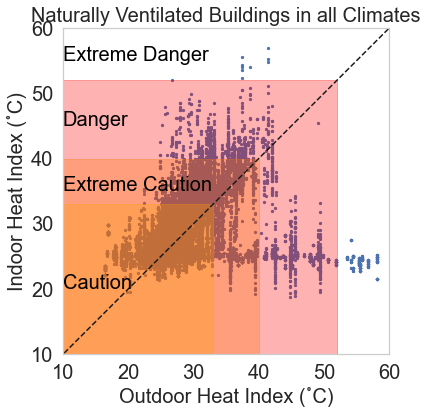

In [126]:
# scatter plot the indoor and outdoor heat index
import matplotlib.pyplot as plt
plt.scatter(df_data_plot['hi_out'], df_data_plot['hi_in'], s=5)
plt.xlabel('Outdoor Heat Index (˚C)', fontsize=20)
plt.ylabel('Indoor Heat Index (˚C)', fontsize=20)
plt.title('Naturally Ventilated Buildings in all Climates', fontsize=20)

# plot the 1:1 line
plt.plot([0, 100], [0, 100], 'k--')

# plot x<33 and y<33 to indicate the caution zone of heat index
plt.fill_between([10, 33], 10, 33, color='yellow', alpha=0.3)
# plot x<40 and y<40 to indicate the extreme caution zone of heat index
plt.fill_between([10, 40], 10, 40, color='orange', alpha=0.3)
# plot x<52 and y<52 to indicate the danger zone of heat index
plt.fill_between([10, 52], 10, 52, color='red', alpha=0.3)


# the plot should start from 20
plt.xlim(10, 60)
plt.ylim(10, 60)

# increase the x and y axis tick size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# set the aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')
# increase the plot size
plt.gcf().set_size_inches(6, 6)
# remove the grid
plt.grid(False)
# show the color of three zones
plt.text(10, 20, 'Caution', fontsize=20, color='black')
plt.text(10, 35, 'Extreme Caution', fontsize=20, color='black')
plt.text(10, 45, 'Danger', fontsize=20, color='black')
plt.text(10, 55, 'Extreme Danger', fontsize=20, color='black')

# plt.show()

In [66]:
df_data.climate.unique()

array(['humid subtropical', 'humid midlatitude', 'mediterranean',
       'west coast marine', 'hot arid', 'tropical savanna',
       'temperature marine', 'continental subarctic', 'wet equatorial',
       'tropical wet savanna', 'desert (hot arid)',
       'semi arid midlatitude', 'semi arid high altitude',
       'temperate oceanic', 'temperate', 'hot semi-arid',
       'monsoon-influenced humid subtropical', 'tropical rainforest',
       'cold semi-arid', 'hot desert', 'hot-summer mediterranean',
       'monsoon-influenced hot-summer humid continental',
       'tropical dry savanna', 'tropical', 'warm-summer mediterranean',
       'warm-summer\xa0humid continental'], dtype=object)

In [127]:
# select climates: humid subtropical, monsoon-influenced humid subtropical, tropical rainforest, monsoon-influenced hot-summer humid continental
df_data_plot = df_data_plot[df_data_plot['climate'].isin(['humid subtropical', 
                                                          'monsoon-influenced humid subtropical',
                                                          'tropical rainforest',
                                                          'monsoon-influenced hot-summer humid continental'])]


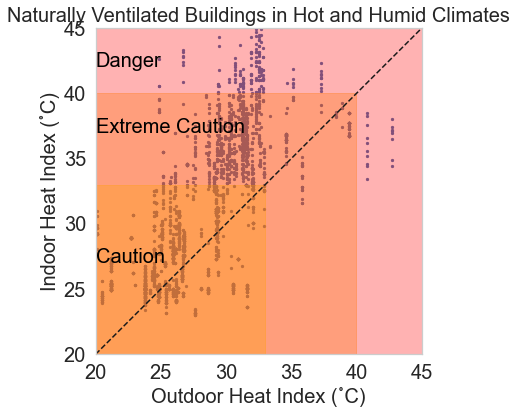

In [128]:

# scatter plot the indoor and outdoor heat index
import matplotlib.pyplot as plt
plt.scatter(df_data_plot['hi_out'], df_data_plot['hi_in'], s=5)
plt.xlabel('Outdoor Heat Index (˚C)', fontsize=20)
plt.ylabel('Indoor Heat Index (˚C)', fontsize=20)
plt.title('Naturally Ventilated Buildings in Hot and Humid Climates', fontsize=20)

# plot the 1:1 line
plt.plot([20, 45], [20, 45], 'k--')

# plot x<33 and y<33 to indicate the caution zone of heat index
plt.fill_between([20, 33], 20, 33, color='yellow', alpha=0.3)
# plot x<40 and y<40 to indicate the extreme caution zone of heat index
plt.fill_between([20, 40], 20, 40, color='orange', alpha=0.3)
# plot x>40 and y>40 to indicate the danger zone of heat index
plt.fill_between([20, 45], 20, 45, color='red', alpha=0.3)

# the plot should start from 20
plt.xlim(20, 45)
plt.ylim(20, 45)

# increase the x and y axis tick size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# set the aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')
# increase the plot size
plt.gcf().set_size_inches(6, 6)
# remove the grid
plt.grid(False)

# show the color of three zones
plt.text(20, 27, 'Caution', fontsize=20, color='black')
plt.text(20, 37, 'Extreme Caution', fontsize=20, color='black')
plt.text(20, 42, 'Danger', fontsize=20, color='black')

plt.show()